In [1]:
import numpy as np
import pandas as pd
import os,time, matplotlib
import matplotlib.pyplot as plt
import datetime,time,json
import multiprocessing

from newsplease import NewsPlease
from utils import GoogleNews

# Start Loading all files from folder

In [2]:
INPUT_PATH = '../data/articles'

In [3]:
paths = [os.path.join(INPUT_PATH,x) for x in os.listdir(INPUT_PATH)]

In [4]:
alldicts = []
for file in paths:
    with open(file,'r') as fi:
        try:
            d = json.load(fi)
            alldicts.append(d)
        except Exception as e:
            pass

In [5]:
df = pd.DataFrame(alldicts).dropna(subset = 'maintext').reset_index(drop=True)

# Data Cleaning 
Remove incorrect results like scraping errors

In [6]:
# Filter out newline escape chars

df = df.assign(maintext = df.maintext.str.replace('\n',' '))

print('Initial Number of articles:',len(df))

Initial Number of articles: 22036


## cleaning should take care of incorrect text: javascript browser cookies
Out of all articles N are featuring web error related stopwords, as initial preprocessing we can discard them

In [16]:
check = df.maintext.str.contains('java|javascript|cookie|browser', regex=True)
check.sum()

887

In [17]:
for row in  df[check].maintext.drop_duplicates():
    print(row)
    print('-----')
    break

Why did this happen?
Please make sure your browser supports JavaScript and cookies and that you are not blocking them from loading. For more information you can review our Terms of Service and Cookie Policy.
-----


In [18]:
df = df[-check]

In [24]:
round(len(df)/(len(df)+887),2), len(df)

(0.96, 21149)

# Preprocessing

In [26]:
# To lower case
df['maintext'] = df.maintext.str.lower()
df['title'] = df.title.str.lower()

# Remove commas
df['maintext'] = df['maintext'].str.replace('[,;/]','', regex=True)

## add country info

In [27]:
countries = ['uk','usa','Austria','Belgium','Bulgaria','Croatia',
             'Cyprus','Czech','Denmark',
             'Estonia','Finland','France','Germany','Greece',
             'Hungary','Ireland','Italy','Latvia','Lithuania',
             'Luxembourg','Malta','Netherlands','Poland','Portugal',
             'Romania','Slovakia','Slovenia','Spain','Sweden']
countries = [x.lower() for x in countries]

pat = '|'.join(countries)
pat

'uk|usa|austria|belgium|bulgaria|croatia|cyprus|czech|denmark|estonia|finland|france|germany|greece|hungary|ireland|italy|latvia|lithuania|luxembourg|malta|netherlands|poland|portugal|romania|slovakia|slovenia|spain|sweden'

In [28]:
words = df.maintext.str.split('\s+', regex=True)
country = df.maintext.str.findall(pat)

df = df.assign(country = country.apply(lambda x: list(set(x))))

## Check text length

it might make sense to just drop articles incredibly long

In [29]:
df = df.assign(numchars = df.maintext.apply(lambda x: len(x.replace(' ',''))))
df = df.assign(numwords = df.maintext.apply(lambda x: len(x.split(' '))))
df.head()

,id,title,link,published,maintext,country,numchars,numwords
0,8f585a5d26a3b5820b5f7e1e3feec996,coronavirus - austria travel advice - gov.uk,https://www.gov.uk/foreign-travel-advice/austr...,"Sat, 21 Mar 2020 10:13:56 GMT",coronavirus travel health\ncheck the latest in...,"[uk, austria, ireland]",4225,763
1,2ce54f3940c5e94a29387852d3f4b282,cdc study shows unvaccinated people are 29 tim...,https://www.cnbc.com/2021/08/24/cdc-study-show...,"Tue, 24 Aug 2021 07:00:00 GMT",medics transfer a patient on a stretcher from ...,[],2126,404
2,cdafae70c4e76a5cb4ac8de7fe64b314,here's how the last pandemic vaccine was rolle...,https://www.healthline.com/health-news/what-ha...,"Mon, 10 Aug 2020 07:00:00 GMT",share on pinterest families wait for the h1n1 ...,[],3956,782
3,300c572c2e471d8044c04d5d49902b9f,opinion | will we struggle to reach herd immun...,https://www.nytimes.com/interactive/2021/03/26...,"Fri, 26 Mar 2021 07:00:00 GMT",illustration by brian stauffer\nhere’s the goo...,[],9286,1918
4,187e2dff43d693610498830a9ee59a13,italy mandates covid vaccine for those over 50...,https://www.newsweek.com/italy-mandates-covid-...,"Thu, 06 Jan 2022 08:00:00 GMT",as the death toll from the covid-19 omicron va...,"[germany, italy, greece, austria]",2924,567


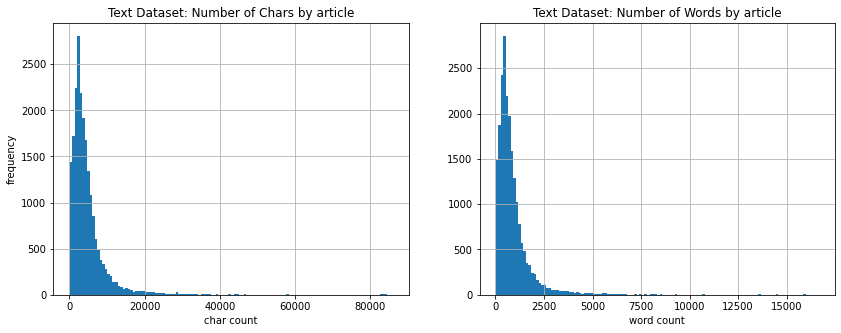

In [30]:
fig,[ax,ax2] = plt.subplots(figsize = (14,5), ncols=2)
df.numchars.hist(bins=128,ax=ax)
df.numwords.hist(bins=128,ax=ax2)

ax.set_xlabel('char count')
ax2.set_xlabel('word count')

ax.set_ylabel('frequency')
ax.set_title('Text Dataset: Number of Chars by article')
ax2.set_title('Text Dataset: Number of Words by article')
plt.show()

In [31]:
quantiles90 = df[['numchars','numwords']].apply(lambda x :x.quantile(.9).round(-3))

quantiles90

numchars    9000.0
numwords    2000.0
dtype: float64

In [32]:
df = df[(df.numwords<=quantiles90.numchars) & (df.numchars<=quantiles90.numchars)]

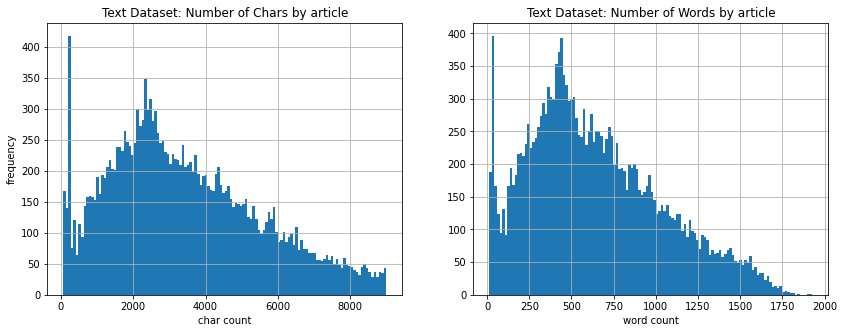

In [33]:
fig,[ax,ax2] = plt.subplots(figsize = (14,5), ncols=2)
df.numchars.hist(bins=128,ax=ax)
df.numwords.hist(bins=128,ax=ax2)

ax.set_xlabel('char count')
ax2.set_xlabel('word count')

ax.set_ylabel('frequency')
ax.set_title('Text Dataset: Number of Chars by article')
ax2.set_title('Text Dataset: Number of Words by article')
plt.show()

In [36]:
len(df), round(len(df)/24001,2)

(18838, 0.78)

In [19]:
# Lowerbound

quantiles10 = df[['numchars','numwords']].apply(lambda x :x.quantile(.01).round(-1))

quantiles10

numchars    150.0
numwords     30.0
dtype: float64

In [19]:
for i in df[df.numwords<25].maintext:
    print('---------')
    print(i)    

---------
a tourist on a boat on the southern thai island of koh phi phi in 2019. photo: afp
---------
hong kong confirmed nine new coronavirus cases on sunday all among arrivals on inbound flights. photo: k. y. cheng
---------
logo_ddn_tag_site jn with tagline logo-sns_tag_site our apologies unfortunately our website is currently unavailable in most european countries due to gdpr rules.
---------
covid live news updates: delhi reports 1414 new covid-19 cases 1171 recoveries and 1 death in the last 24 hours
---------
people are monitored for any reactions after receiving coronavirus vaccine shots in beijing last month. photo: kyodo
---------
residents wait in line for biontech inoculation at a mobile vaccination station in shek kip mei on sunday. photo: yik yeung man
---------
travellers arrive at singapore’s changi airport. visitors are flocking to the quarantine-free city state. photo: afp
---------
omicron covid news updates: new guidelines for international arrivals 14 days travel 

In [20]:
# Number of articles by date

In [20]:
dates = (pd.to_datetime(df.published)).dt.to_period('M')

/home/rba/Projects/cultural-analytics/venv_culturalanalytics/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:>

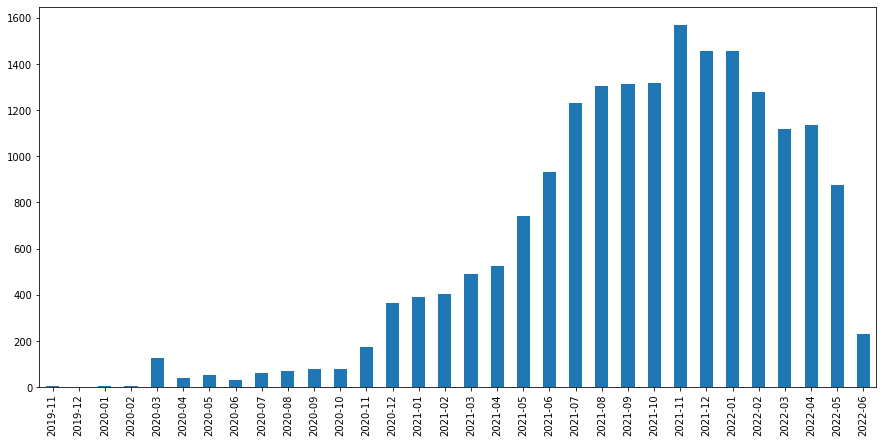

In [21]:
dates.value_counts().sort_index().plot.bar(figsize=(15,7))

# Save Dataset

In [22]:
df.head()

,id,title,link,published,maintext,country,numchars,numwords
0,8f585a5d26a3b5820b5f7e1e3feec996,coronavirus - austria travel advice - gov.uk,https://www.gov.uk/foreign-travel-advice/austr...,"Sat, 21 Mar 2020 10:13:56 GMT",coronavirus travel health check the latest inf...,"[uk, ireland, austria]",4189,799
1,2ce54f3940c5e94a29387852d3f4b282,cdc study shows unvaccinated people are 29 tim...,https://www.cnbc.com/2021/08/24/cdc-study-show...,"Tue, 24 Aug 2021 07:00:00 GMT",medics transfer a patient on a stretcher from ...,[],2122,408
2,cdafae70c4e76a5cb4ac8de7fe64b314,here's how the last pandemic vaccine was rolle...,https://www.healthline.com/health-news/what-ha...,"Mon, 10 Aug 2020 07:00:00 GMT",share on pinterest families wait for the h1n1 ...,[],3952,786
4,187e2dff43d693610498830a9ee59a13,italy mandates covid vaccine for those over 50...,https://www.newsweek.com/italy-mandates-covid-...,"Thu, 06 Jan 2022 08:00:00 GMT",as the death toll from the covid-19 omicron va...,"[italy, greece, austria, germany]",2908,583
6,b65c939453403440b5318bfd3fcb70e0,reader question: do international school teach...,https://www.thelocal.it/20210816/reader-questi...,"Mon, 16 Aug 2021 07:00:00 GMT",question: i’ve been hired to teach at an inter...,"[italy, uk]",4813,964


In [24]:
df.shape

(18862, 8)

In [23]:
df.to_csv('../data/text_dataset/articles_v1.csv',sep=';', index=None)
df.to_excel('../data/text_dataset/articles_v1.xlsx',index=None)
df.to_pickle('../data/text_dataset/articles_v1.pickle')